#  Chemical Langevin equation

$$
X_i(t+\tau) = X_i(t) + \sum_{j=1}^M \nu_{ji} \left[ a_j(x_t)\tau + \left( a_j(x_t)\tau \right)^{1/2} \mathcal{N}(0,1) \right]
$$

In [1]:
import sys
sys.path.insert(1, "../..")

# Numpy is used to set the timespan of the Model.
import numpy
import scipy
# Import the types that'll be needed to define your Model.
from gillespy2.core import (
    Model,
    Species,
    Reaction,
    Parameter
)

In [2]:
class MichaelisMenten(Model):
     def __init__(self, scaling=1):

            # Intialize the Model with a name of your choosing.
            Model.__init__(self, name="Michaelis_Menten")
            
            """
            Parameters are constant values relevant to the system, such as reaction kinetic rates.
            
            - name: A user defined name for reference.
            - expression: Some constant value.
            """

            rate1 = Parameter(name="rate1", expression=0.0017/scaling)
            rate2 = Parameter(name="rate2", expression=0.5)
            rate3 = Parameter(name="rate3", expression=0.1)
            
            # Add the Parameters to the Model.
            self.add_parameter([rate1, rate2, rate3])
            
            """
            Species can be anything that participates in or is produced by a reaction channel.
            
            - name: A user defined name for the species.
            - initial_value: A value/population count of species at start of simulation.
            """

            A = Species(name="A", initial_value=301*scaling)
            B = Species(name="B", initial_value=120*scaling)
            C = Species(name="C", initial_value=0)
            D = Species(name="D", initial_value=0)
            
            # Add the Species to the Model.
            self.add_species([A, B, C, D])
            
            """
            Reactions are the reaction channels which cause the system to change over time.
            
            - name: A user defined name for the reaction.
            - reactants: A dictionary with participant reactants as keys, and consumed per reaction as value.
            - products: A dictionary with reaction products as keys, and number formed per reaction as value.
            - rate: A parameter rate constant to be applied to the propensity of this reaction firing.
            - propensity_function: Can be used instead of rate in order to declare a custom propensity function in string format.
            """

            r1 = Reaction(
                    name="r1",
                    reactants={A: 1, B: 1}, 
                    products={C: 1},
                    rate=rate1
                )
            
            r2 = Reaction(
                    name="r2",
                    reactants={C: 1}, 
                    products={A: 1, B: 1},
                    rate=rate2
                )
            
            r3 = Reaction(
                    name="r3",
                    reactants={C: 1}, 
                    products={B: 1, D: 1},
                    rate=rate3
                )
            
            # Add the Reactions to the Model.
            self.add_reaction([r1, r2, r3])
            
            # Use NumPy to set the timespan of the Model.
            self.timespan(numpy.linspace(0, 100, 101))

In [3]:
model = MichaelisMenten()

In [4]:
%time result = model.run(algorithm="SSA")

Wall time: 3.81 s


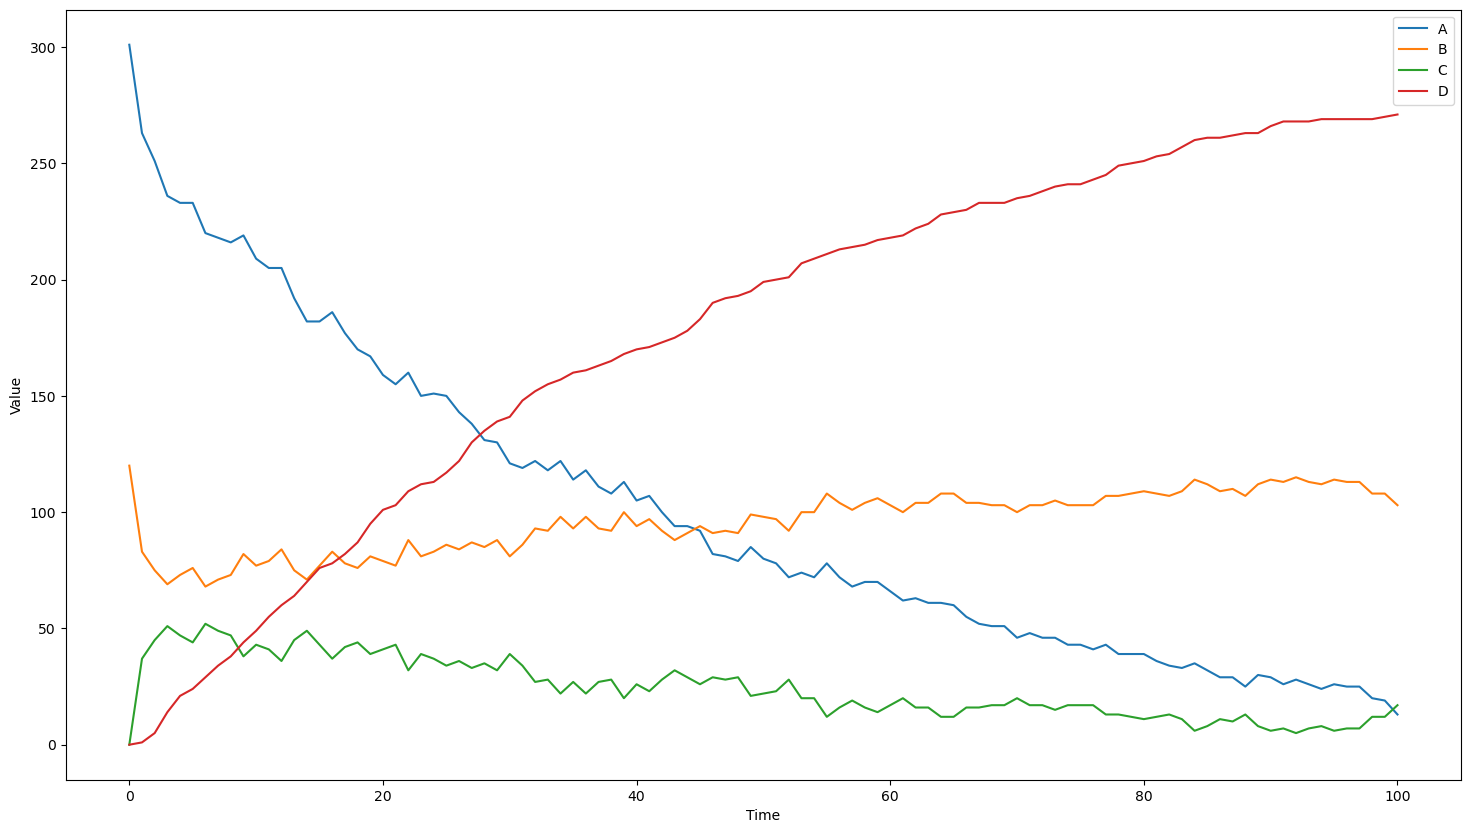

In [5]:
result.plot()

In [6]:
model2 = MichaelisMenten(2)

In [7]:
%time result2 = model2.run(algorithm="SSA")

Wall time: 3.71 s


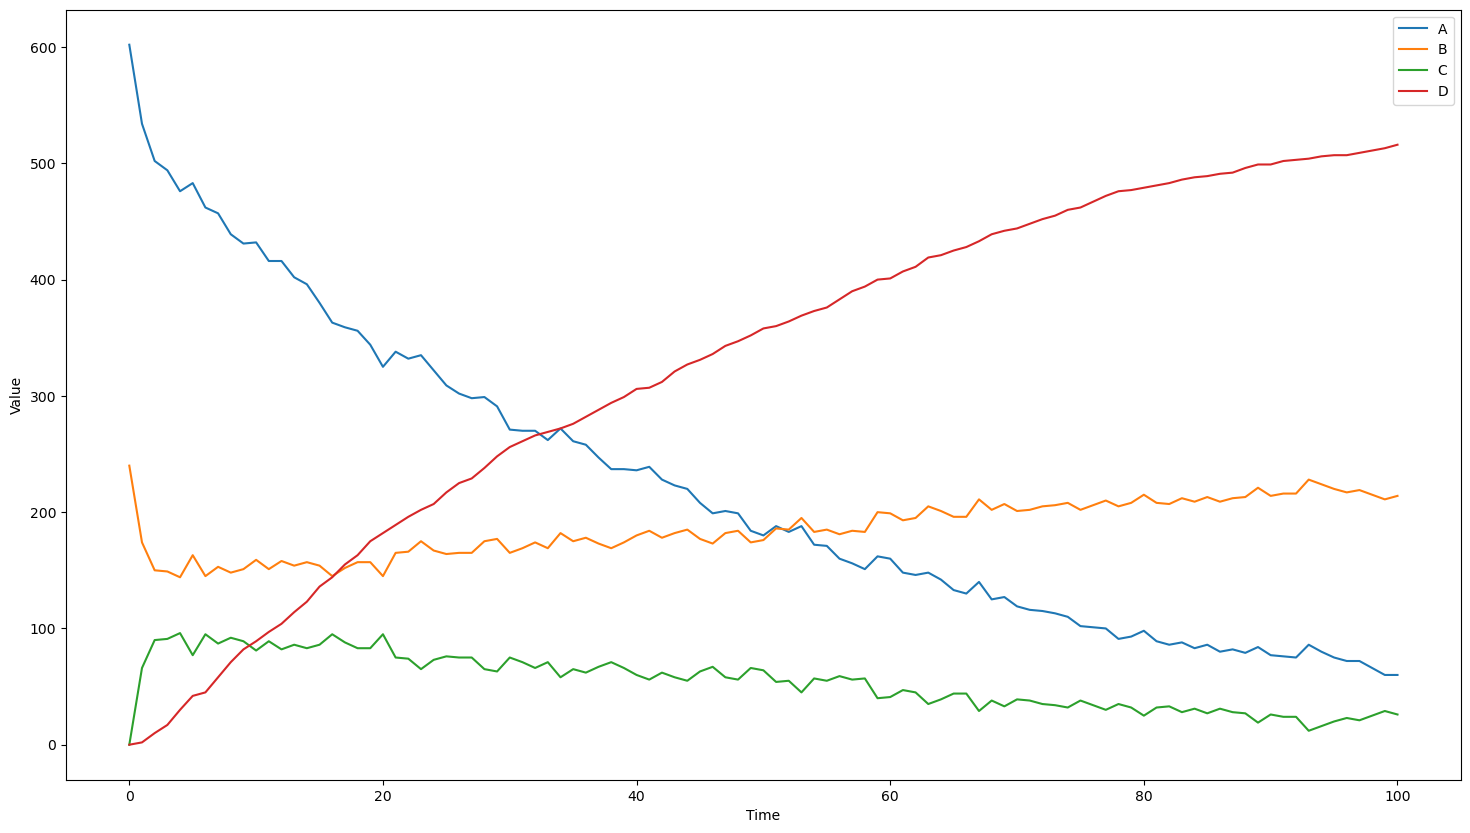

In [8]:
result2.plot()

Wall time: 3.63 s


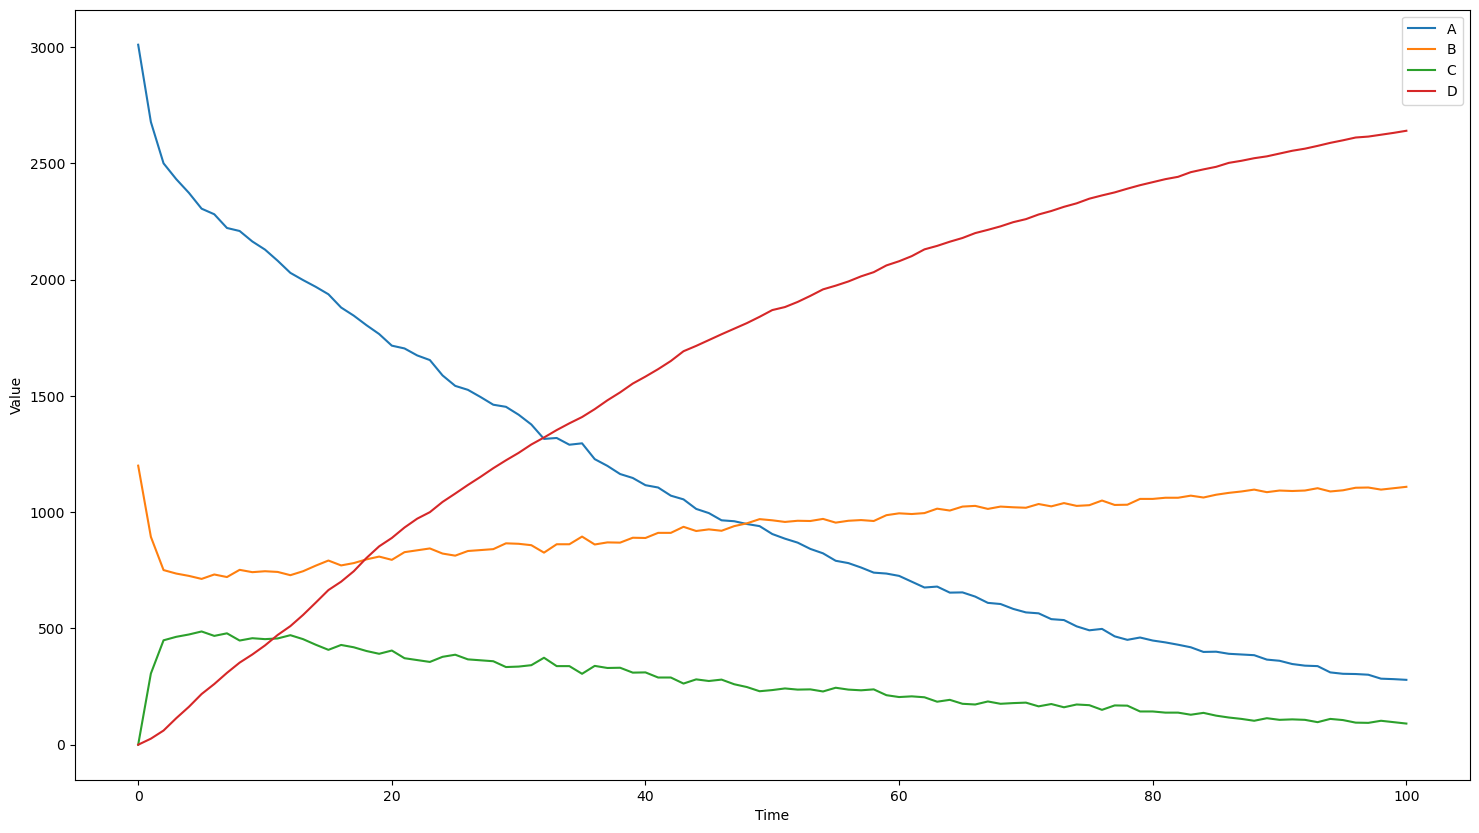

In [9]:
model10 = MichaelisMenten(10)
%time result10 = model10.run(algorithm="SSA")
result10.plot()

Wall time: 3.7 s


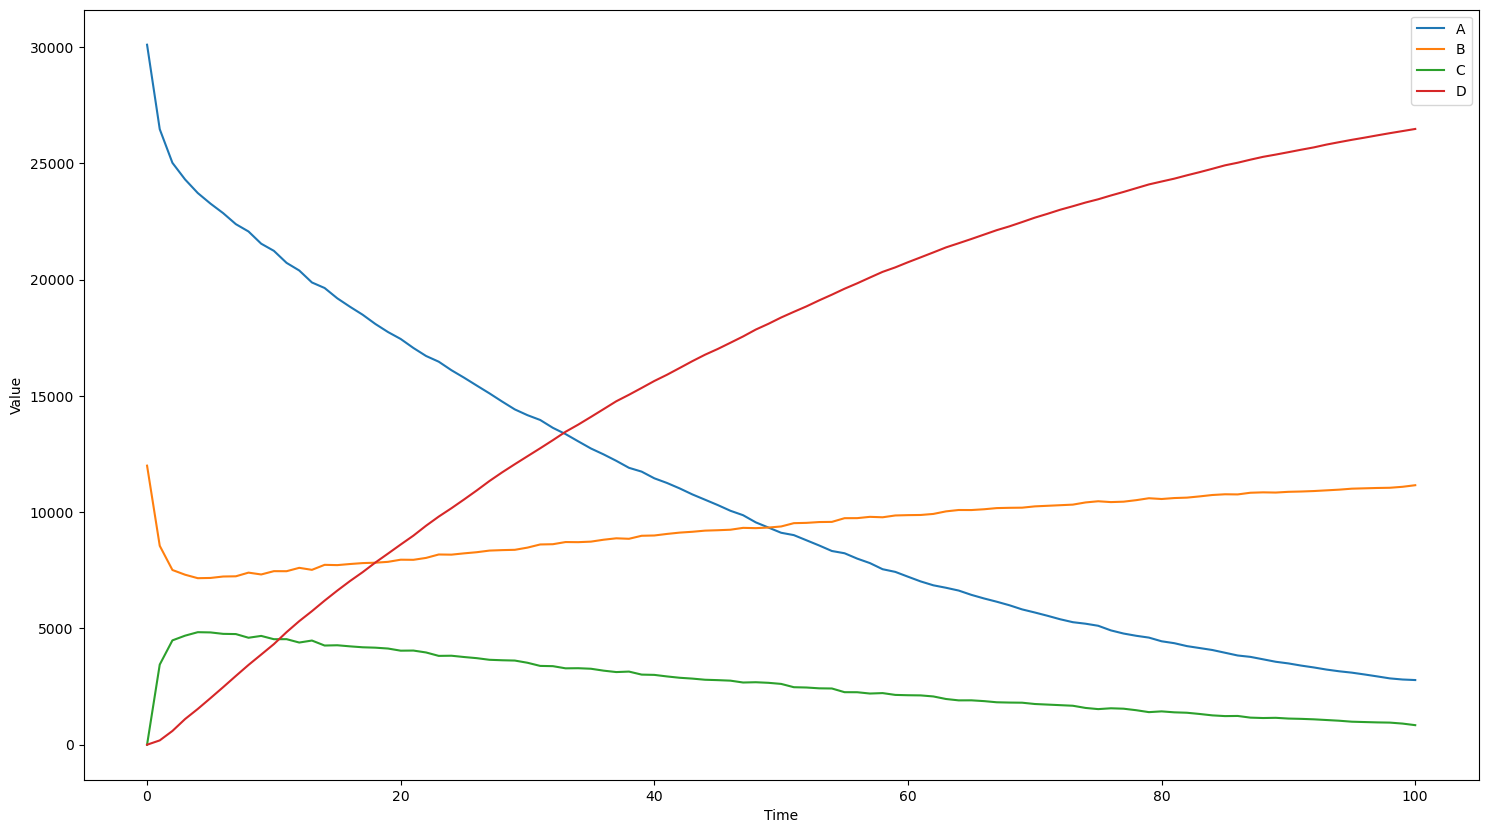

In [10]:
model100 = MichaelisMenten(100)
%time result100 = model100.run(algorithm="SSA")
result100.plot()

Wall time: 8.87 s


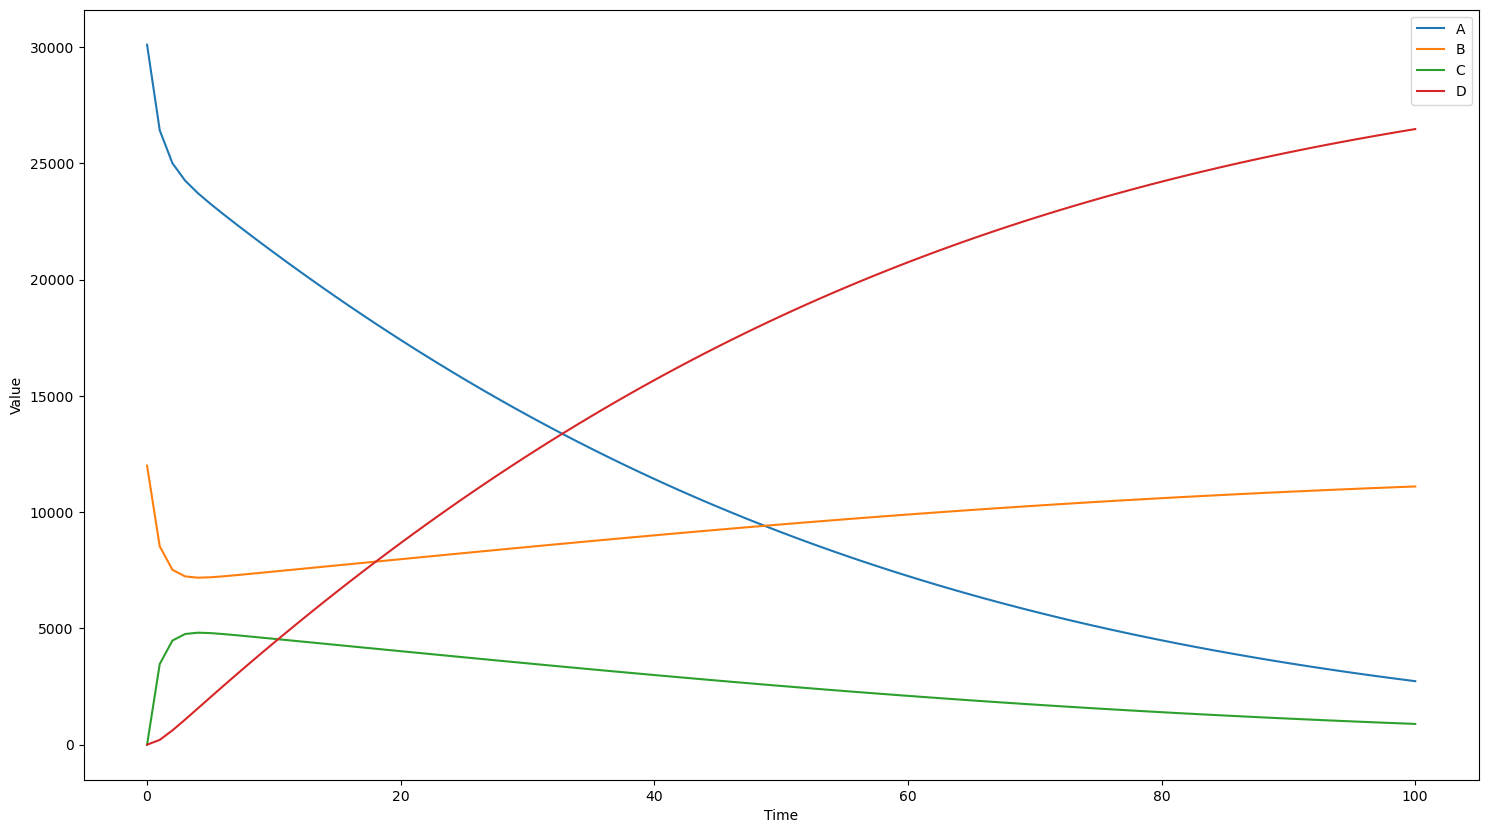

In [11]:
%time dresult100 = model100.run(algorithm="ODE")
dresult100.plot()

Wall time: 104 ms


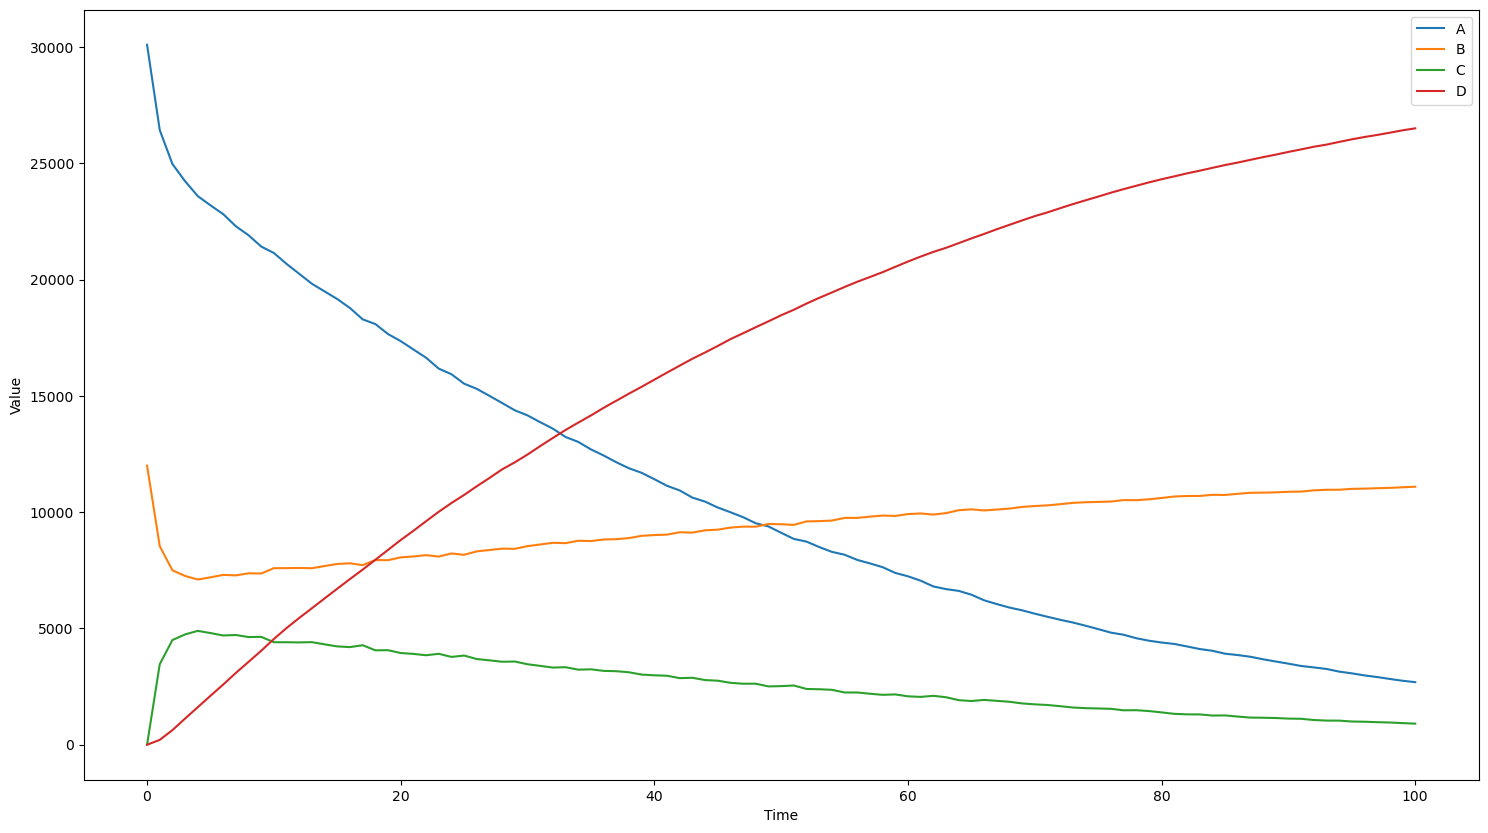

In [12]:
from gillespy2 import CLESolver
%time cresult100 = model100.run(solver=CLESolver)
cresult100.plot()

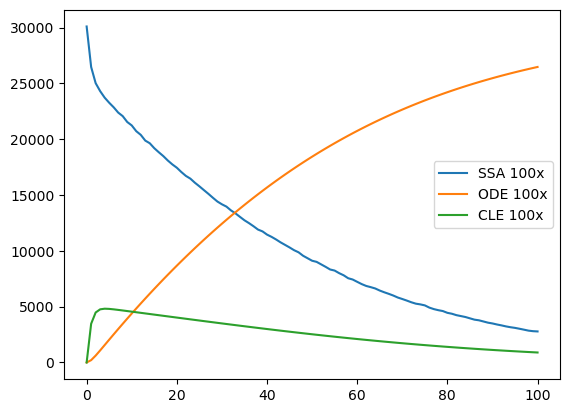

In [13]:
import matplotlib.pyplot as plt

plt.plot(result100['time'],result100['A'],label='SSA 100x')
plt.plot(dresult100['time'],dresult100['D'],label='ODE 100x')
plt.plot(cresult100['time'],dresult100['C'],label='CLE 100x')
plt.legend(loc='best')

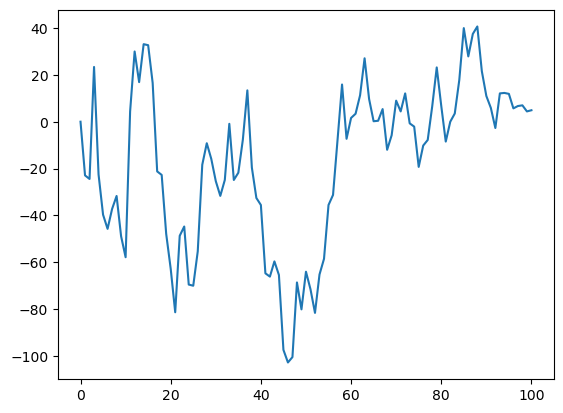

In [14]:
plt.plot(result100['time'],(result100['D']-dresult100['D']))

In [15]:
def ode_cle_ssa_distance(n):
    m = MichaelisMenten(n)
    s = m.run(model.get_best_solver_algo("SSA")(m))
    c = m.run(solver=CLESolver)
    o = m.run(model.get_best_solver_algo("ODE")(m))
    #sc= abs(numpy.max((s['D']-c['D'])))
    #so= abs(numpy.max((s['D']-o['D'])))
    #co= abs(numpy.max((c['D']-o['D'])))
    sc= scipy.linalg.norm(s['D']/n - c['D']/n)
    so= scipy.linalg.norm(s['D']/n - o['D']/n)
    co= scipy.linalg.norm(c['D']/n - o['D']/n)
    return {'sc':sc,'so':so,'co':co,'s':s,'c':c,'o':o}

def plot_d(d):
    for l in ['sc','so','co']:
        print(f"{l}: {d[l]}")
    for l in ['s','c','o']:
        plt.plot(d[l]['time'],d[l]['D'], label=l)
    plt.legend(loc='best')


In [16]:
%time d = ode_cle_ssa_distance(100)

Wall time: 11.6 s


sc: 8.483460393402721
so: 11.193271068481286
co: 6.213808903633421


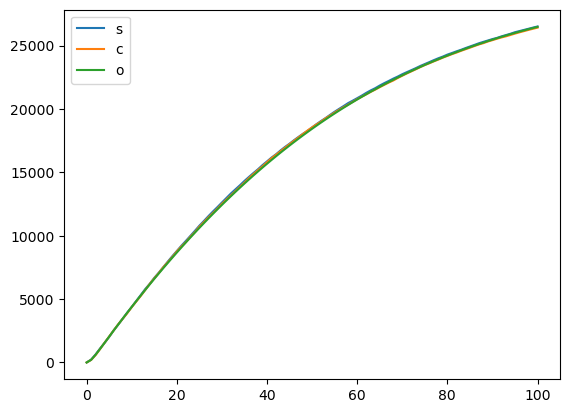

In [17]:
plot_d(d)

Wall time: 19 s
sc: 0.6254119403062982
so: 0.8425744072187455
co: 0.5060692657359085


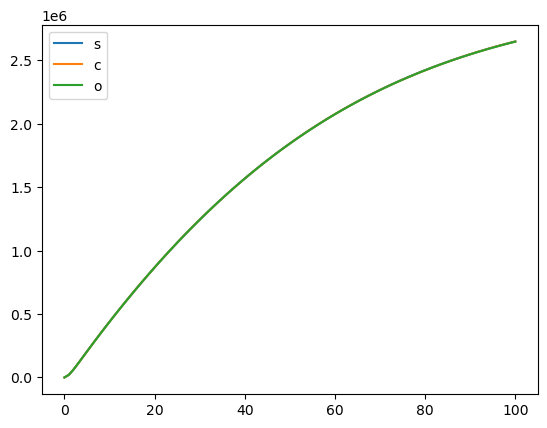

In [18]:
%time d5 = ode_cle_ssa_distance(10000)
plot_d(d5)

In [19]:
nlist=[10,50,100,500,1000,5000,10000]
def convergence_study():  
    global nlist
    clist = []
    for n in nlist:
        print(f"n={n}")
        clist.append(ode_cle_ssa_distance(n))
    return clist

In [20]:
%time clist = convergence_study()

n=10
n=50
n=100
n=500
n=1000
n=5000
n=10000
Wall time: 1min 31s


sc=[22.2192876440227, 22.242588392008038, 14.166082970300284, 4.522271749971536, 2.018379431387437, 2.2763028340988503, 0.6361866707966499]
so=[15.007911879145578, 19.853867212168037, 6.2581585320683715, 3.8894201774043475, 3.0017843930735686, 1.6387695063064909, 1.4210749599159118]
co=[21.357367294044128, 5.444483531833179, 12.707997274388141, 3.145202914638497, 2.2953807373700426, 0.6887179255719592, 1.1435620660375079]


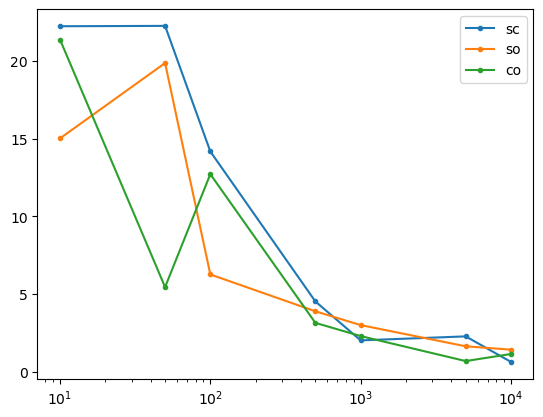

In [21]:
sc=[]
so=[]
co=[]
for c in clist:
    sc.append(c['sc'])
    so.append(c['so'])
    co.append(c['co'])
plt.semilogx(nlist,sc,'.-',label='sc')
print(f"sc={sc}")
plt.semilogx(nlist,so,'.-',label='so')
print(f"so={so}")
plt.semilogx(nlist,co,'.-',label='co')
print(f"co={co}")
plt.legend(loc='best')